 LOADING COVER IMAGE AND DISPLAYING IT

In [ ]:
from PIL import Image
import numpy as np

def load_color_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_rgb = np.array(img, dtype=np.uint8)
    return img_rgb

def int_to_8bit_binary(value):
    return format(int(value), '08b')


def rgb_pixel_to_8bit(rgb_pixel):
    r, g, b = rgb_pixel
    return (
        int_to_8bit_binary(r),
        int_to_8bit_binary(g),
        int_to_8bit_binary(b)
    )


def image_rgb_to_8bit(img_rgb):
    H, W, _ = img_rgb.shape
    img_bin = [[[None, None, None] for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            r, g, b = img_rgb[i, j]
            img_bin[i][j][0] = int_to_8bit_binary(r)
            img_bin[i][j][1] = int_to_8bit_binary(g)
            img_bin[i][j][2] = int_to_8bit_binary(b)

    return img_bin


: 

In [ ]:
def preprocess_cover_to_8bit(image_path):
    img_rgb= load_color_image(image_path)
    img_bin= image_rgb_to_8bit(img_rgb)
    return img_bin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_cover_image(cover_img_bin, title="Cover Image", save_path=None):
    """
    cover_img_bin : (H,W,3) where each entry is an 8-bit string
    """

    H = len(cover_img_bin)
    W = len(cover_img_bin[0])

    img = np.zeros((H, W, 3), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            img[i, j, 0] = int(cover_img_bin[i][j][0], 2)  # R
            img[i, j, 1] = int(cover_img_bin[i][j][1], 2)  # G
            img[i, j, 2] = int(cover_img_bin[i][j][2], 2)  # B

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


LOADING SECRET IMAGE (8 BIT), CONVERSION (6BIT), RESHAPING(TO FIT COVER) AND THEN DISPLAYING IT

In [ ]:
from PIL import Image
import numpy as np
import math

def load_gray_image(image_path):
    img = Image.open(image_path).convert("L")
    img_gray = np.array(img, dtype=np.uint8)
    return img_gray



def grayscale_to_8bit_binary(img_gray):
    H, W = img_gray.shape
    bin_img = [[None for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            bin_img[i][j] = format(int(img_gray[i, j]), '08b')
    return bin_img


def flatten_binary_image(bin_img):
    bitstream = []

    for row in bin_img:
        for pixel_bin in row:
            bitstream.extend([int(b) for b in pixel_bin])
    return bitstream



def split_to_6bit_blocks(bitstream):
    padding = (6 - (__builtins__.len(bitstream) % 6)) % 6
    bitstream = bitstream + [0] * padding

    blocks_6bit = []
    for i in range(0, __builtins__.len(bitstream), 6):
        blocks_6bit.append(bitstream[i:i+6])
    return blocks_6bit



def reshape_blocks_to_2d(blocks_6bit, W_cover):

    M = len(blocks_6bit)
    H_needed = math.ceil(M / W_cover)

    # Padding blocks if necessary
    padded_blocks = blocks_6bit + [[0]*6] * (H_needed * W_cover - M)

    # Build 2D structure
    blocks_2d = []
    for y in range(H_needed):
        row = padded_blocks[y*W_cover : (y+1)*W_cover]
        blocks_2d.append(row)

    return blocks_2d


def pad_2d_to_power_of_two(blocks_2d):
    H = len(blocks_2d)
    W = len(blocks_2d[0])

    H2 = 1 << math.ceil(math.log2(H))
    W2 = 1 << math.ceil(math.log2(W))

    zero_block = [0]*6
    # Pad rows
    for row in blocks_2d:
        row.extend([zero_block] * (W2 - W))
    # Pad columns
    for _ in range(H2 - H):
        blocks_2d.append([zero_block] * W2)
    return blocks_2d


In [ ]:
def preprocess_grayscale_to_6bit_2d(image_path,l):
    img_gray = load_gray_image(image_path)
    bin_img = grayscale_to_8bit_binary(img_gray)
    bitstream = flatten_binary_image(bin_img)
    blocks_6bit = split_to_6bit_blocks(bitstream)
    blocks_2d=reshape_blocks_to_2d(blocks_6bit,l)
    img_gray_6= pad_2d_to_power_of_two(blocks_2d)
    return img_gray_6



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_secret_before_decomposition(secret_gray, title="Secret Image (Original)", save_path=None):
    
    img_gray = load_gray_image(secret_gray)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_gray, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


In [ ]:

def display_secret_after_decomposition(img_gray_6, title="Secret Image After Decomposition", save_path=None):

    H = len(img_gray_6)
    W = len(img_gray_6[0])

    img = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            bits = img_gray_6[i][j]          # [b5,b4,b3,b2,b1,b0]
            value = int("".join(map(str, bits)), 2)
            img[i, j] = value                # 0–63

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=63)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


EMBEDDING DECOMPOSED IMAGE INTO COVER IMAGE

In [ ]:
def int_to_binary(x, width):
    return format(x, f'0{width}b')

def gray_code_conv(l):
    assert len(l) == 4
    return [l[0], l[0]^l[1], l[1]^l[2], l[2]^l[3]]

def gray_parity(l):
    return gray_code_conv(l)[-1]   # 0 = even, 1 = odd

def flip_bit(bit_char):
    return '1' if bit_char == '0' else '0'


def embed_into_cover(img_bin, img_gray):
    """
    img_bin  : (N,N,3) 8-bit strings
    img_gray : (N,N,6) secret bits
    returns  : stego_img_bin
    """

    N = len(img_bin)
    stego_img_bin = [[list(img_bin[i][j]) for j in range(N)] for i in range(N)]

    for i in range(N):
        for j in range(N):

            pix_r, pix_g, pix_b = stego_img_bin[i][j]
            s = img_gray[i][j]   # [s5,s4,s3,s2,s1,s0]

            R = list(pix_r)
            G = list(pix_g)
            B = list(pix_b)

            g_R = [int(R[k]) for k in [3,4,5,6]] 
            g_G = [int(G[k]) for k in [3,4,5,6]]
            g_B = [int(B[k]) for k in [3,4,5,6]]

           
            if (s[0] == 1 and gray_parity(g_R) == 0) or \
               (s[0] == 0 and gray_parity(g_R) == 1):
                R[6] = flip_bit(R[6])   # flip r1

            if (s[1] == 1 and gray_parity(g_G) == 0) or \
               (s[1] == 0 and gray_parity(g_G) == 1):
                G[6] = flip_bit(G[6])

            if (s[2] == 1 and gray_parity(g_B) == 0) or \
               (s[2] == 0 and gray_parity(g_B) == 1):
                B[6] = flip_bit(B[6])

            g_R = [int(R[k]) for k in [4,5,6,7]] 
            g_G = [int(G[k]) for k in [4,5,6,7]]
            g_B = [int(B[k]) for k in [4,5,6,7]]

            if (s[3] == 1 and gray_parity(g_R) == 0) or \
               (s[3] == 0 and gray_parity(g_R) == 1):
                R[7] = flip_bit(R[7])   # flip r0

            if (s[4] == 1 and gray_parity(g_G) == 0) or \
               (s[4] == 0 and gray_parity(g_G) == 1):
                G[7] = flip_bit(G[7])

            if (s[5] == 1 and gray_parity(g_B) == 0) or \
               (s[5] == 0 and gray_parity(g_B) == 1):
                B[7] = flip_bit(B[7])

            stego_img_bin[i][j] = [
                ''.join(R),
                ''.join(G),
                ''.join(B)
            ]

    return stego_img_bin


In [ ]:
def display_stego_image(stego_img_bin, title="Stego Image", save_path=None):

    N = len(stego_img_bin)
    img = np.zeros((N, N, 3), dtype=np.uint8)

    for i in range(N):
        for j in range(N):
            img[i, j, 0] = int(stego_img_bin[i][j][0], 2)  # R
            img[i, j, 1] = int(stego_img_bin[i][j][1], 2)  # G
            img[i, j, 2] = int(stego_img_bin[i][j][2], 2)  # B

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


EXTRACTING IMAGE FROM STEGO-IMAGE

In [ ]:
def extract_from_stego(stego_img_bin):
   

    N = len(stego_img_bin)
    img_gray_6bit = [[[0]*6 for _ in range(N)] for _ in range(N)]

    for i in range(N):
        for j in range(N):

            pix_r, pix_g, pix_b = stego_img_bin[i][j]

            R = list(map(int, pix_r))
            G = list(map(int, pix_g))
            B = list(map(int, pix_b))

            # For s0, s1, s2 
            gR1 = [R[k] for k in [3,4,5,6]]  
            gG1 = [G[k] for k in [3,4,5,6]]
            gB1 = [B[k] for k in [3,4,5,6]]

            s0 = gray_parity(gR1)
            s1 = gray_parity(gG1)
            s2 = gray_parity(gB1)

            # For  s3, s4, s5
            gR2 = [R[k] for k in [4,5,6,7]]  
            gG2 = [G[k] for k in [4,5,6,7]]
            gB2 = [B[k] for k in [4,5,6,7]]

            s3 = gray_parity(gR2)
            s4 = gray_parity(gG2)
            s5 = gray_parity(gB2)

            img_gray_6bit[i][j] = [s0, s1, s2, s3, s4, s5]

    return img_gray_6bit


In [ ]:
def display_secret_after_extraction(img_gray_6bit, title="Secret Image After Extraction", save_path=None):

    H = len(img_gray_6bit)
    W = len(img_gray_6bit[0])

    img = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            bits = img_gray_6bit[i][j]          # [b5,b4,b3,b2,b1,b0]
            value = int("".join(map(str, bits)), 2)
            img[i, j] = value                # 0–63

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=63)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


RECONSTRUCTION OF 8BIT FORM OF SECRET IMAGE


In [ ]:
import numpy as np

def reconstruct_grayscale_from_extraction(img_gray_6_extracted,N,Hs, Ws):
    bitstream = []
    for y in range(N):
        for x in range(N):
            bitstream.extend(img_gray_6_extracted[y][x])

    total_secret_bits = 8 * Hs * Ws
    bitstream = bitstream[:total_secret_bits]

    pixels = []
    for i in range(0, len(bitstream), 8):
        byte = bitstream[i:i+8]
        pixels.append(int("".join(map(str, byte)), 2))

    recons_img_gray = np.array(pixels, dtype=np.uint8).reshape(Hs, Ws)
    return recons_img_gray

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_secret_reconstruction(recons_gray, title="Secret Image (Reconstructed)", save_path=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(recons_gray, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()

COMPARISION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def compare_secret_images(
    original,
    reconstructed,
    title_prefix="Secret Image Comparison",
    save_path=None
):

    # Convert to numpy arrays
    # orig = np.array(original, dtype=np.float64)
    # rec  = np.array(reconstructed, dtype=np.float64)
    orig = original
    rec = reconstructed
    assert orig.shape == rec.shape, "Image sizes must match"

    
    diff = orig - rec

    mse = np.mean(diff ** 2)
    mae = np.mean(np.abs(diff))

    if mse == 0:
        psnr = float("inf")
    else:
        psnr = 10 * math.log10((255 ** 2) / mse)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(orig, cmap="gray", vmin=0, vmax=255)
    plt.title("Original Secret")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rec, cmap="gray", vmin=0, vmax=255)
    plt.title("Reconstructed Secret")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(np.abs(diff), cmap="hot")
    plt.title("Absolute Difference")
    plt.axis("off")

    plt.suptitle(
        f"{title_prefix}\n"
        f"MSE={mse:.4f}, MAE={mae:.4f}, PSNR={psnr:.2f} dB"
    )

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()
    return {
        "MSE": mse,
        "MAE": mae,
        "PSNR": psnr
    }


In [ ]:
def master_function(color_path,secret_path):
 #Load images
 img_rgb = load_color_image(color_path)
 img_gray = load_gray_image(secret_path)
 img_bin = preprocess_cover_to_8bit(color_path)
 img_gray_6 = preprocess_grayscale_to_6bit_2d(secret_path,img_rgb.shape[0])

#Display originals
 display_cover_image(img_bin)
 display_secret_before_decomposition(secret_path)

#Display decomposed
 display_secret_after_decomposition(img_gray_6)

#Embed
 stego_img_bin = embed_into_cover(img_bin, img_gray_6)

#Display stego
 display_cover_image(stego_img_bin, "Stego Image")

#Extract
 img_gray_6bit = extract_from_stego(stego_img_bin)

#Reconstruct
 reconstructed_secret = reconstruct_grayscale_from_extraction(
    img_gray_6bit,
    N=img_rgb.shape[0],
    Hs=img_gray.shape[0],
    Ws=img_gray.shape[1]
)

#Compare
 compare_secret_images(img_gray, reconstructed_secret)


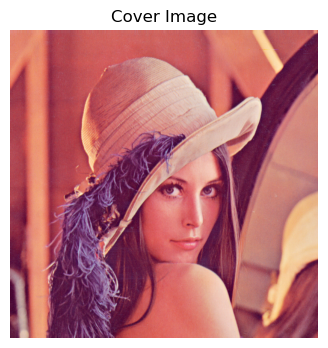

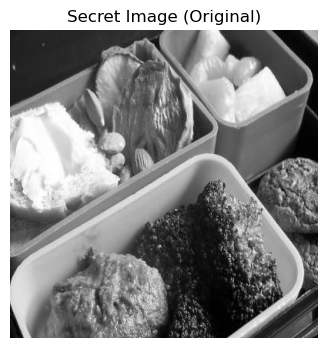

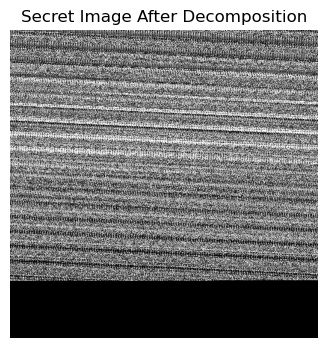

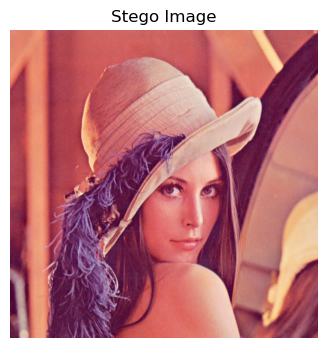

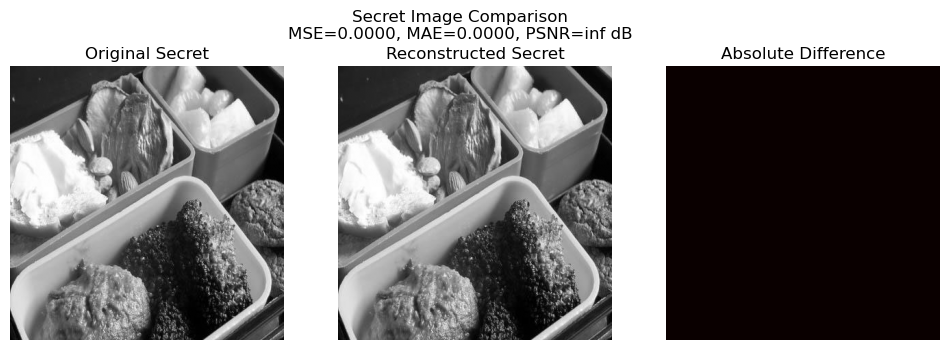

In [ ]:
master_function("cover4x4.jpg","secret4x2.jpg")